In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import warnings
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

import kerastuner as kt


from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user
import datetime
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
    

In [3]:
train = pd.read_csv('data/L.POINT_train.csv', encoding='UTF-8')
test = pd.read_csv('data/L.POINT_test.csv', encoding='UTF-8')

In [4]:
y_train =  pd.read_csv('data/y_train.csv')

In [5]:
train['PD_BUY_AM']  = train['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
train['PD_BUY_CT']  = train['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )
train['TOT_SESS_HR_V']  = train['TOT_SESS_HR_V'].map(lambda x: int(str(x).replace(',','')) )

test['PD_BUY_AM']  = test['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
test['PD_BUY_CT']  = test['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )
test['TOT_SESS_HR_V']  = test['TOT_SESS_HR_V'].map(lambda x: int(str(x).replace(',','')) )

In [6]:
train['AMOUNT'] = train['PD_BUY_AM'] * train['PD_BUY_CT']
test['AMOUNT'] = test['PD_BUY_AM'] * test['PD_BUY_CT']

In [7]:
train['date'] = pd.to_datetime(train['SESS_DT'], format= '%Y%m%d')
test['date'] = pd.to_datetime(test['SESS_DT'], format= '%Y%m%d')

word2vec

In [83]:
train['PD_C']=train['PD_C'].astype('str')
test['PD_C']=test['PD_C'].astype('str')

In [91]:
import random

train_data = list(train.groupby('CLNT_ID')['CLAC3_NM'].unique())
test_data = list(test.groupby('CLNT_ID')['CLAC3_NM'].unique())

In [92]:
def oversample(x, n,seed=0):
    lst = []
    for i in x:
        tmp = []
        np.random.seed(seed)
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [93]:
w2v_input = oversample(train_data, 10)

In [94]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 60, window = 5, min_count = 1, sg = 1,seed=0)

In [95]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(60)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 150000/150000 [00:02<00:00, 51828.72it/s]


In [96]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(60)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 113104/113104 [00:02<00:00, 52532.26it/s]


In [97]:
train_mean_vector = pd.DataFrame(train_mean_vector)
test_mean_vector = pd.DataFrame(test_mean_vector)

In [98]:
train_mean_vector.isnull().sum().sum(),test_mean_vector.isnull().sum().sum()

(0, 0)

In [99]:
import pickle
## save
with open('train_mean_vector_clac3.pickle', 'wb') as f:
    pickle.dump(train_mean_vector, f, pickle.HIGHEST_PROTOCOL)

In [100]:
import pickle
## save
with open('test_mean_vector_clac3.pickle', 'wb') as f:
    pickle.dump(test_mean_vector, f, pickle.HIGHEST_PROTOCOL)

In [176]:
# load
with open('train_mean_vector_clac3.pickle', 'rb') as f:
    train_mean_vector_clac3 = pickle.load(f)

with open('test_mean_vector_clac3.pickle', 'rb') as f:
    test_mean_vector_clac3 = pickle.load(f)

In [177]:
# load
with open('train_mean_vector.pickle', 'rb') as f:
    train_mean_vector_pdc = pickle.load(f)

with open('test_mean_vector.pickle', 'rb') as f:
    test_mean_vector_pdc = pickle.load(f)

In [178]:
data=pd.concat([train.groupby('CLNT_ID').PD_ADD_NM.first().reset_index(),train_mean_vector_pdc],axis=1).drop('PD_ADD_NM',axis=1)
data_te=pd.concat([test.groupby('CLNT_ID').PD_ADD_NM.first().reset_index(),test_mean_vector_pdc],axis=1).drop('PD_ADD_NM',axis=1)

In [179]:
data=pd.concat([data,train_mean_vector_clac3],axis=1)
data_te=pd.concat([data_te,test_mean_vector_clac3],axis=1)

In [180]:
cust_tr = data.CLNT_ID
cust_te = data_te.CLNT_ID 

In [181]:
X = data.drop(columns=['CLNT_ID'])
X_test = data_te.drop(columns=['CLNT_ID'])

y =  pd.read_csv('data/y_train.csv').LABEL

In [183]:
X.columns=np.arange(1,161)
X_test.columns=np.arange(1,161)

In [186]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import ShuffleSplit

100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [1:02:11<00:00, 39.28s/it]

(98, -1.2619433668257964)


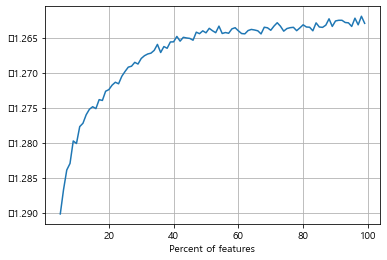

In [187]:
from sklearn.naive_bayes import GaussianNB
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMClassifier()

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X, y)    
    cv_score = cross_val_score(model, X_new, y, scoring='neg_log_loss', cv=sscv).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [188]:
fs = SelectPercentile(percentile=best_score[0]).fit(X, y)
train_selected = fs.transform(X)
test_selected = fs.transform(X_test)
X_train_select=pd.DataFrame(train_selected,columns=X.columns[fs.get_support()].tolist())
X_test_select=pd.DataFrame(test_selected,columns=X.columns[fs.get_support()].tolist())

In [189]:
###################코드 돌아가면 소리 나는거################### 
import winsound as sd
def beepsound():
    fr = 2000    # range : 37 ~ 32767
    du = 1000     # 1000 ms = =1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)
beepsound()
##############################################################

In [198]:
fs.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

#### Bayesian Opt

In [203]:
ftr = X_train_select
target=y

In [204]:
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization

In [205]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((105000, 156), (45000, 156))

In [206]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [207]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', verbose=100, 
                early_stopping_rounds=100)
    valid_pred = lgb_model.predict_proba(valid_x)
    log_score = log_loss(valid_y, valid_pred)
    
    return log_score

In [208]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.2371	valid_1's multi_logloss: 1.27677
[200]	training's multi_logloss: 1.19047	valid_1's multi_logloss: 1.26106
[300]	training's multi_logloss: 1.1555	valid_1's multi_logloss: 1.25557
[400]	training's multi_logloss: 1.12508	valid_1's multi_logloss: 1.25306
[500]	training's multi_logloss: 1.09754	valid_1's multi_logloss: 1.25177
[600]	training's multi_logloss: 1.07218	valid_1's multi_logloss: 1.25118
Early stopping, best iteration is:
[594]	training's multi_logloss: 1.07364	valid_1's multi_logloss: 1.25115
|  1        |  1.251    |  0.7744   |  360.4    |  12.82    |  113.5    |  21.76    |  49.84    |  21.88    |  8.918    |  0.9

[600]	training's multi_logloss: 1.11609	valid_1's multi_logloss: 1.25177
[700]	training's multi_logloss: 1.0979	valid_1's multi_logloss: 1.25122
[800]	training's multi_logloss: 1.08084	valid_1's multi_logloss: 1.25088
[900]	training's multi_logloss: 1.06502	valid_1's multi_logloss: 1.25087
Early stopping, best iteration is:
[855]	training's multi_logloss: 1.07201	valid_1's multi_logloss: 1.25084
|  9        |  1.251    |  0.6409   |  182.8    |  11.53    |  43.94    |  33.35    |  40.72    |  29.16    |  6.572    |  0.7809   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.24975	valid_1's multi_logloss: 1.28123
[200]	training's multi_logloss: 1.21168	valid_1's multi_logloss: 1.26498
[300]	training's multi_logloss: 1.1856	valid_1's multi_logloss: 1.25917
[400]	training's multi_logloss: 1.16409	valid_1's multi_logloss: 1.25626
[500]	training's multi_logloss: 1.14521	valid_1's multi_logloss: 1.25472
[600]	training's multi_logloss: 1.12889	v

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.24287	valid_1's multi_logloss: 1.27799
[200]	training's multi_logloss: 1.2006	valid_1's multi_logloss: 1.26219
[300]	training's multi_logloss: 1.16979	valid_1's multi_logloss: 1.25666
[400]	training's multi_logloss: 1.14339	valid_1's multi_logloss: 1.25418
[500]	training's multi_logloss: 1.11959	valid_1's multi_logloss: 1.25286
[600]	training's multi_logloss: 1.0979	valid_1's multi_logloss: 1.25228
[700]	training's multi_logloss: 1.07779	valid_1's multi_logloss: 1.252
[800]	training's multi_logloss: 1.05885	valid_1's multi_logloss: 1.25199
Early stopping, best iteration is:
[788]	training's multi_logloss: 1.06104	valid_1's multi_logloss: 1.25197
|  18       |  1.252    |  0.8263   |  179.0    |  12.19    |  25.42    |  22.47    |  41.44    |  25.05    |  2.005    |  0.6375   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.24952	valid_1's mult

[500]	training's multi_logloss: 1.11282	valid_1's multi_logloss: 1.25272
[600]	training's multi_logloss: 1.09007	valid_1's multi_logloss: 1.25179
[700]	training's multi_logloss: 1.06905	valid_1's multi_logloss: 1.25146
[800]	training's multi_logloss: 1.04979	valid_1's multi_logloss: 1.25143
Early stopping, best iteration is:
[723]	training's multi_logloss: 1.06451	valid_1's multi_logloss: 1.25139
|  25       |  1.251    |  0.7945   |  227.7    |  11.99    |  10.97    |  29.73    |  58.59    |  36.54    |  5.997    |  0.619    |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.22961	valid_1's multi_logloss: 1.27438
[200]	training's multi_logloss: 1.17739	valid_1's multi_logloss: 1.25878
[300]	training's multi_logloss: 1.13674	valid_1's multi_logloss: 1.25388
[400]	training's multi_logloss: 1.10108	valid_1's multi_logloss: 1.25166
[500]	training's multi_logloss: 1.06872	valid_1's multi_logloss: 1.25067
[600]	training's multi_logloss: 1.03889

In [209]:
lgbBO.res

[{'target': 1.251146063157274,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 1.2536079279558263,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 1.2537370982337765,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.61248

In [210]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('minimum target index:', np.argmin(np.array(target_list)))

[1.251146063157274, 1.2536079279558263, 1.2537370982337765, 1.2526450634067101, 1.251539019715117, 1.2515545762500302, 1.2514505369806355, 1.2515572769761272, 1.2508394162461933, 1.2527097968044187, 1.2520945234432344, 1.2528328393216073, 1.2519671546389504, 1.253959469706834, 1.2525457708379533, 1.2510676893709294, 1.250315865641987, 1.251966081274364, 1.2521979538448818, 1.2514699948335697, 1.2510131394284554, 1.2525896341228486, 1.252474625990353, 1.2516714146870185, 1.2513901962123721, 1.2502695116165727, 1.2517675926801293, 1.2526101568809276, 1.2507038020187256, 1.2531644776798476]
minimum target index: 25


In [211]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
min_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(min_dict)

{'target': 1.2502695116165727, 'params': {'colsample_bytree': 0.5220894724290079, 'max_bin': 85.94837484270441, 'max_depth': 13.637802636589656, 'min_child_samples': 31.69873590274043, 'min_child_weight': 25.53921945576096, 'num_leaves': 55.779419530470044, 'reg_alpha': 13.89522161333654, 'reg_lambda': 1.522069194132511, 'subsample': 0.9647340498702532}}


In [212]:
ftr = X_train_select
target=y

In [216]:
X_tst=pd.read_csv('data/sample_submission.csv')

In [218]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 6))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                n_jobs=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=14,
                num_leaves=56,
                colsample_bytree=0.5221,
                subsample=0.9647,
                max_bin=86,
                reg_alpha=13.8952,
                reg_lambda=1.5220,
                min_child_weight=25.5392,
                min_child_samples=32,
                silent=-1,
                verbose=-1,
                )
    
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx,:]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx,:]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]    
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_test_select, num_iteration=clf.best_iteration_)/folds.n_splits
             
    return clf, test_preds

In [219]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 1.23506	valid_1's multi_logloss: 1.27517
[400]	training's multi_logloss: 1.18753	valid_1's multi_logloss: 1.25902
[600]	training's multi_logloss: 1.15117	valid_1's multi_logloss: 1.25344
[800]	training's multi_logloss: 1.11934	valid_1's multi_logloss: 1.25078
[1000]	training's multi_logloss: 1.09058	valid_1's multi_logloss: 1.24953
[1200]	training's multi_logloss: 1.06415	valid_1's multi_logloss: 1.24904
[1400]	training's multi_logloss: 1.03942	valid_1's multi_logloss: 1.24878
[1600]	training's multi_logloss: 1.01622	valid_1's multi_logloss: 1.24897
Early stopping, best iteration is:
[1453]	training's multi_logloss: 1.03314	valid_1's multi_logloss: 1.24876
##### iteration 1 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 1.23631	valid_1's multi_logloss: 1.27079
[400]	training's multi_logloss: 1.18871	valid_1's multi_logloss:

In [220]:
###################코드 돌아가면 소리 나는거################### 
import winsound as sd
def beepsound():
    fr = 2000    # range : 37 ~ 32767
    du = 1000     # 1000 ms = =1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)
beepsound()
##############################################################

In [221]:
X_tst[X_tst.columns[1:]] = test_preds

In [222]:
X_tst.set_index('CLNT_ID',inplace=True)

In [224]:
X_tst.to_csv('11_23_w2v.csv')